## Overview of `pylabianca`
This notebook offers a relatively short overview of the `pylabianca` package.
It is not meant to be a comprehensive tutorial, but rather a quick overview of
some of the functionality.

In [1]:
import os
import os.path as op

Set up paths to the data, residing on OneDrive in BIDS format. You need to have
OneDrive installed on your computer and synced with the cloud. Below,
`sarna` package is used to locate the OneDrive folder.


In [6]:
import sarna

onedrive_dir = sarna.proj.find_onedrive(kind='business')

superdual_dir = op.join(onedrive_dir, 'RESEARCH', 'superdual')
beh_data_dir = op.join(superdual_dir, r'sourcedata\sub-U10\ses-main\beh')
raw_data_dir = op.join(superdual_dir, r'sub-U10\ses-main\ieeg',
                       'sub-U10_ses-main_task-superdual_run-01_ieeg')
spike_data_dir = op.join(superdual_dir, 'derivatives\example\sub-U10',
                         r'osorted\mixed\5')

The spiking data we use here have not been curated, so likely there are many
false positive units, and duplicates due to reference signal have not been
removed. The files used here are only from MTL contacts, but still, including
waveforms the files take around 2 GB.

In [7]:
os.listdir(spike_data_dir)[:10]

['A153_sorted_new.mat',
 'A154_sorted_new.mat',
 'A155_sorted_new.mat',
 'A156_sorted_new.mat',
 'A157_sorted_new.mat',
 'A158_sorted_new.mat',
 'A159_sorted_new.mat',
 'A160_sorted_new.mat',
 'A161_sorted_new.mat',
 'A162_sorted_new.mat']

We can read a directory of osort files using `pylabianca.io.read_osort`. This function can read data files saved either in the standard osort or "mm" formats. The data we use here have not been curated and re-exported, so they are in standard osort format. We will also read the waveforms for all the units - but reading waveforms takes a while (5 - 10 seconds).

In [9]:
import pylabianca as pln

spk = pln.io.read_osort(spike_data_dir, waveform=True, format='standard')

100%|██████████| 32/32 [00:06<00:00,  4.99it/s]


The `spk` variable we got is a `pylabianca.Spikes` object:

In [10]:
spk

<Spikes, 347 cells, 966.6 spikes/cell on average>

We will not discuss the internal structure of the `Spikes` object here, as we will mostly work on epoched data (and thus `SpikeEpochs` object will be used). But we'll plot a wavefrom density plot for one example unit, just to show that it is simple (you can change the value of the `pick` argument to see waveforms for other units):

<AxesSubplot:xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>

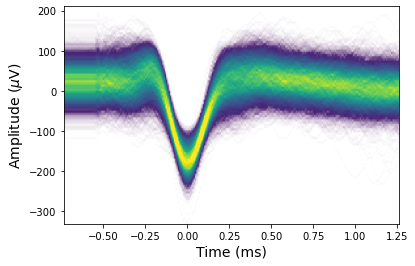

In [18]:
spk.plot_waveform(pick=6)

Don't look at the time axis for now, it is not correct - I'll have to make sure what is the upsampling performed by osort. We can perform some additional upsampling ourselves:

<AxesSubplot:xlabel='Time (ms)', ylabel='Amplitude ($\\mu$V)'>

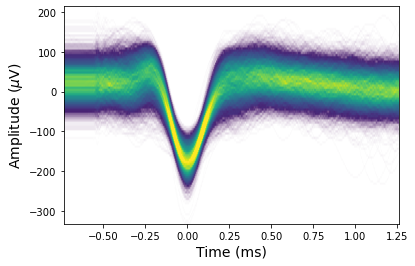

In [22]:
spk.plot_waveform(pick=6, upsample=3)

Before moving further we will perform a simple cells selection. We will remove any units that have less than 100 spikes recorded:

In [30]:
min_spikes = 100
sel = spk.n_spikes() >= min_spikes
spk.pick_cells(sel)

<Spikes, 296 cells, 1118.5 spikes/cell on average>

From initial 347 units we are now left with 296.  
Note that `.pick_cells()` method works in place and our original object is modified now (to work on a copy use `spk_sel = spk.copy().pick_cells(sel)`):

In [31]:
spk

<Spikes, 296 cells, 1118.5 spikes/cell on average>

### Reading events and epoching data

We now want to epoch the data with respect to image presentation. For this we will have to read the events from the raw NCS directory. We could also read `events.tsv` in BIDS format, but we will not do it here.  
  
Reading raw Neuralynx files requires NeuralynxIO package (at least for now), you can get it from github:  
[link](https://github.com/alafuzof/NeuralynxIO)  
we will also make sure it is on `PYTHONPATH` so that it imports ok.

In [25]:
import sys

sys.path.append(r'C:\src\NeuralynxIO')

NeuralynxIO is a bit slow and throws a lot of warnings for the new ATLAS files, but we will live with it for now. We ask for `format='mne'` to get a n_events x 3 array instead of a dataframe.

In [28]:
events = pln.io.read_neuralynx_events(raw_data_dir, format='mne')

C:\src\NeuralynxIO\neuralynx_io\neuralynx_io.py:78: UserWarning: Unable to parse original file path from Neuralynx header: -FileType Event
  warnings.warn('Unable to parse original file path from Neuralynx header: ' + hdr_lines[1])
C:\src\NeuralynxIO\neuralynx_io\neuralynx_io.py:130: UserWarning: Unable to parse time string from Neuralynx header: -FileVersion 3.2
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
C:\src\NeuralynxIO\neuralynx_io\neuralynx_io.py:130: UserWarning: Unable to parse time string from Neuralynx header: -FileUUID 7fcbbbef-7031-4885-993f-6166c3448912
  warnings.warn('Unable to parse time string from Neuralynx header: ' + time_string)
C:\src\NeuralynxIO\neuralynx_io\neuralynx_io.py:92: UserWarning: Unable to parse parameter line from Neuralynx header: -OriginalFileName D:\U10\20221117\superdual 2\2022-11-17_15-51-42\Events.nev
  warnings.warn('Unable to parse parameter line from Neuralynx header: ' + line)
C:\src\NeuralynxIO\neur

Let's take a look at how the events are represented:

In [29]:
events[:10]

array([[1668700445811391,                0,              100],
       [1668700446827047,                0,              130],
       [1668700453721231,                0,              241],
       [1668700456008480,                0,              100],
       [1668700457507542,                0,              130],
       [1668700459615010,                0,              242],
       [1668700461069416,                0,              100],
       [1668700462563384,                0,              130],
       [1668700464336665,                0,              241],
       [1668700465843851,                0,              100]],
      dtype=int64)

The events are read in mne-python compatible format: the first column is the timestamp, while the last one is the trigger value.  
In superdual the images are represented by trigger values `110 + image_index`, so these are: 110, 111, and 112.